1) Clone https://github.com/adamnguyenitvn/UIT_bigdata_labs_2019

2) Open Forecasting.ipynb

3) Make a copy of Forecasting.ipynb, name it with your studentID.ipynb

4) Do the exercise

5) Push your Jupyter notebook to github

Note that you should use Python 3 for all exercises.

## TRẦN HOÀNG DŨNG - 16521654

In [2]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [3]:
df = pd.read_csv('data.csv')
df

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118
5,6,9139
6,7,12460
7,8,10717
8,9,7825
9,10,9693


## 1. Visualize and interprete the pattern of this time-series

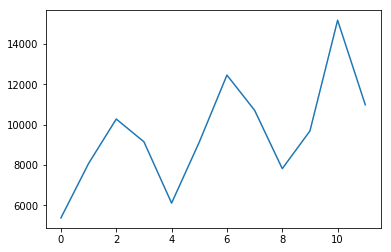

In [4]:
plt.plot(df['Sales'])
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

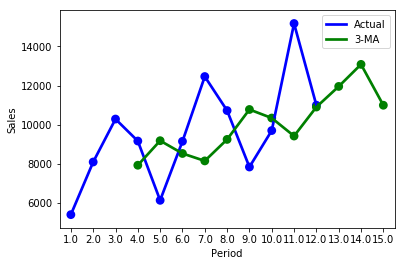

In [46]:

# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    for i in range(1,k+1):
        moving_average_df.loc[i-1]= [i,np.NaN]
    for i in range(k+1,to_period):
        moving_average_df.loc[i-1] = [i,df[i-4:i-1]['Sales'].mean()]
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

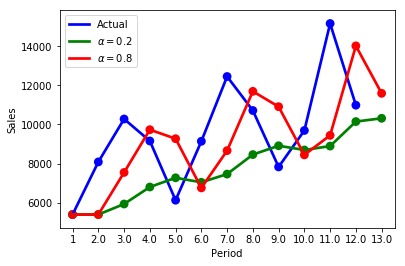

In [152]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = df.loc[0]
    for i in range(1, df.shape[0]+1):
        es_df.loc[i] =  [i+1, (alpha*df.loc[i-1,'Sales'] + (1-alpha)*es_df.loc[i-1,'Sales'])]
    return es_df
    

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')
ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

### Using linear regression

In [188]:
def linear_regression(df):
    #y = a+b*x
    n = len(df)
    x = df['Period']
    y = df['Sales']
    x_mean = x.mean()
    y_mean = y.mean()
    xy_sum = (x*y).sum()
    xx_sum = (x**2).sum()
    b = (xy_sum - n*x_mean*y_mean)/(xx_sum - n*x_mean**2)
    a = y_mean - b*x_mean
    return a,b

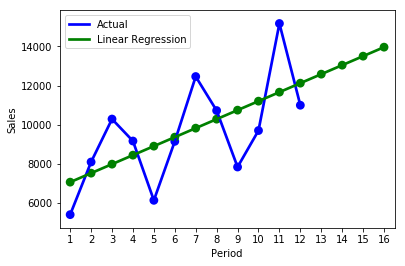

In [189]:
a,b = linear_regression(df)
linear_df = pd.DataFrame(columns=['Period','Sales'])
for m in range(1, 17):
    sale = a + b * m
    linear_df.loc[m-1] = [m,sale]
linear_df['Period'] = linear_df['Period'].astype(int)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=linear_df, color='g')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", "Linear Regression"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality (Optional)

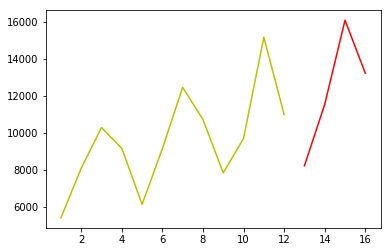

In [199]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    # TODO: Add your code here
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    index_df = pd.DataFrame(columns=['Period','index'])
    mean1 = df[0:4]['Sales'].mean()
    mean2 = df[4:8]['Sales'].mean()
    mean3 = df[8:12]['Sales'].mean()
    mean4 = mean3 + ((mean2-mean1)+(mean3-mean2))/2
    for i in range(df.shape[0]):
        j=0
        if(get_season(df.loc[i])=='I'):
            j = df.loc[i,'Sales']/mean1
        elif(get_season(df.loc[i])=='II'):
            j=df.loc[i,'Sales']/mean2
        else:
            j = df.loc[i,'Sales']/mean3
        index_df.loc[i]=[i+1,j]
    for i in range(12, 16):
        j=i-12
        index =(index_df.loc[j,'index']+index_df.loc[j+4,'index']+index_df.loc[j+8,'index'])/3
        forecast_df.loc[i]=[i+1,mean4*index]
    # End of your coding
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

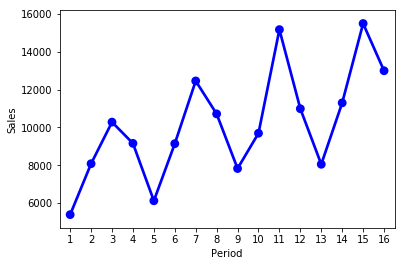

In [9]:
eval_df = pd.read_csv('actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)
sns.pointplot(x='Period', y='Sales', data=eval_df, color='b')

In [10]:
MAD = np.absolute(eval_df['Sales'][12:16] - moving_average(eval_df, 3, 16)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - linear_df['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Linear Regression", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - season_df['Sales'][0:4]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074
MAD of Linear Regression: 2309.1480186480185
MAD of Seasonality Method: 85.88221407247761


In [13]:
MSE = (eval_df['Sales'][12:16] - moving_average(eval_df, 3, 16)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = (eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = (eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = (eval_df['Sales'][12:16] - linear_df['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Linear Regression", MSE))
MSE = (eval_df['Sales'][12:16] - season_df['Sales'][0:4])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 9744054.271861337
MSE of Exponential smoothing with alpha=0.8: 10909182.694821384
MSE of Linear Regression: 7123661.909756519
MSE of Seasonality Method: 22206.08964632527


# Give your conclusion about the above forecastings